## When are Special Interest Groups (SIGs) referenced during meetings?

In [2]:
import pandas as pd
import spacy
import numpy as np
import seaborn as sns

In [37]:
# use three months of data from Seattle, Oakland, and Louisville
# start date of "2022-09-01"
# end date of "2022-12-01"
from cdp_data import CDPInstances, datasets

Seattle_220901_221201 = datasets.get_session_dataset(
    CDPInstances.Seattle,  # specify the city (or county) council we want data from
    start_datetime="2022-09-01",  # YYYY-MM-DD format
    end_datetime="2022-12-01",  # YYYY-MM-DD format
    store_transcript=True,  # store transcripts locally for fast file reading
    store_transcript_as_csv=True,
)
Oakland_220901_221201 = datasets.get_session_dataset(
    CDPInstances.Oakland,  # specify the city (or county) council we want data from
    start_datetime="2022-09-01",  # YYYY-MM-DD format
    end_datetime="2022-12-01",  # YYYY-MM-DD format
    store_transcript=True,  # store transcripts locally for fast file reading
    store_transcript_as_csv=True,
)
Louisville_220901_221201 = datasets.get_session_dataset(
    CDPInstances.Louisville,  # specify the city (or county) council we want data from
    start_datetime="2022-09-01",  # YYYY-MM-DD format
    end_datetime="2022-12-01",  # YYYY-MM-DD format
    store_transcript=True,  # store transcripts locally for fast file reading
    store_transcript_as_csv=True,
)

Fetching each model attached to event_ref:   0%|          | 0/17 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/17 [00:00<?, ?it/s]

Converting and storing each transcript as a CSV: 17it [00:20,  1.23s/it]


Fetching each model attached to event_ref:   0%|          | 0/18 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/18 [00:00<?, ?it/s]

Converting and storing each transcript as a CSV: 18it [00:21,  1.20s/it]


Fetching each model attached to event_ref:   0%|          | 0/77 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/77 [00:00<?, ?it/s]

Converting and storing each transcript as a CSV: 77it [01:19,  1.03s/it]


In [39]:
# Load spacy English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

temp_rows = []
# city = {"Seattle": Seattle_220901_221201}
city = {"Seattle": Seattle_220901_221201, "Oakland": Oakland_220901_221201, "Louisville": Louisville_220901_221201}

for ct, ct_df in city.items():
    # f = city['ct']
    for t in range(len(ct_df)):
        example_session = ct_df.iloc[t]
        # print(example_session)
        sentences = pd.read_csv(example_session.transcript_as_csv_path)
        # can't drop the rows where "text" is NA
        sentences = sentences.dropna(subset=["text"])
        # sentences["text"] = sentences["text"].fillna("NaN")
        # print(sentences)
        # Process sentences in the text column
        for i in sentences.index:
            # spacy
            doc = nlp(sentences[sentences["index"] == i].text.to_string())
            # doc = nlp(sentences["text"][i])
            # print(doc, sentences.index[i])
            for entity in doc.ents:
                temp_rows.append([ct, example_session["id"], "spacy", i, entity.label_, entity.text])

res_df = pd.DataFrame(temp_rows, columns=["city", "session_id", "ner_model", "sentence_index", "named_entity_type", "entity"])
res_df

,city,session_id,ner_model,sentence_index,named_entity_type,entity
0,Seattle,76bba31aaf85,spacy,0,DATE,9:31 A.M.
1,Seattle,76bba31aaf85,spacy,1,CARDINAL,1
2,Seattle,76bba31aaf85,spacy,1,PERSON,Alex Pedersen
3,Seattle,76bba31aaf85,spacy,3,PRODUCT,3 Herbold
4,Seattle,76bba31aaf85,spacy,4,PERCENT,4 Here
...,...,...,...,...,...,...
104463,Louisville,3b14573b464b,spacy,2289,DATE,2289
104464,Louisville,3b14573b464b,spacy,2289,DATE,two weeks
104465,Louisville,3b14573b464b,spacy,2290,DATE,2290
104466,Louisville,3b14573b464b,spacy,2291,CARDINAL,2291


In [108]:
# save res_df to csv file
# res_df.to_csv("NER_3cities_Angel.csv")

In [3]:
# read in the csv
res_df = pd.read_csv("NER_3cities_Angel.csv")

In [4]:
# Add a col that normalizes "sentence_index" to be "percent_progress_in_meeting"
percentage = pd.Series(dtype="float64")
for session in res_df["session_id"].unique():
    temp = res_df[res_df["session_id"] == session]["sentence_index"] / max(res_df[res_df["session_id"] == session]["sentence_index"])
    percentage = pd.concat([percentage, temp])
res_df["percent_progress_in_meeting"] = percentage

In [134]:
per_org_norp_df = res_df[res_df['named_entity_type'].isin(['PERSON', 'ORG', 'NORP'])]
per_org_norp_df

,city,session_id,ner_model,sentence_index,named_entity_type,entity
2,Seattle,76bba31aaf85,spacy,1,PERSON,Alex Pedersen
37,Seattle,76bba31aaf85,spacy,26,PERSON,Greg Spotts
40,Seattle,76bba31aaf85,spacy,28,PERSON,Chamber
45,Seattle,76bba31aaf85,spacy,30,PERSON,Harrell
53,Seattle,76bba31aaf85,spacy,33,ORG,Cou
...,...,...,...,...,...,...
104435,Louisville,3b14573b464b,spacy,2258,PERSON,2258
104444,Louisville,3b14573b464b,spacy,2272,NORP,Asian
104445,Louisville,3b14573b464b,spacy,2272,ORG,LBD
104455,Louisville,3b14573b464b,spacy,2282,PERSON,Arthur


## Plotting

### Average number of entity for each session across all cities

In [6]:
avg_ent_per_sess_city = per_org_norp_df.groupby(by="city")["session_id"].count() / per_org_norp_df.groupby(by="city")["session_id"].nunique()
avg_ent_per_sess_city = avg_ent_per_sess_city.to_frame(name="avg")
avg_ent_per_sess_city = avg_ent_per_sess_city.reset_index()
avg_ent_per_sess_city

,city,avg
0,Louisville,99.649351
1,Oakland,118.666667
2,Seattle,109.294118


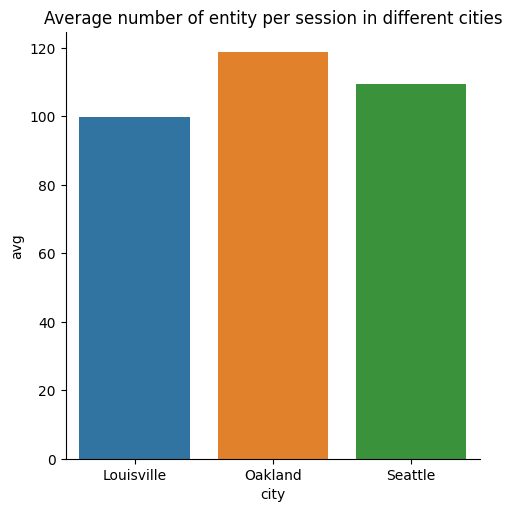

In [7]:
g = sns.catplot(avg_ent_per_sess_city, x='city', y='avg', kind='bar')
_ = g.set(title='Average number of entity per session in different cities')

### Average across all meetings

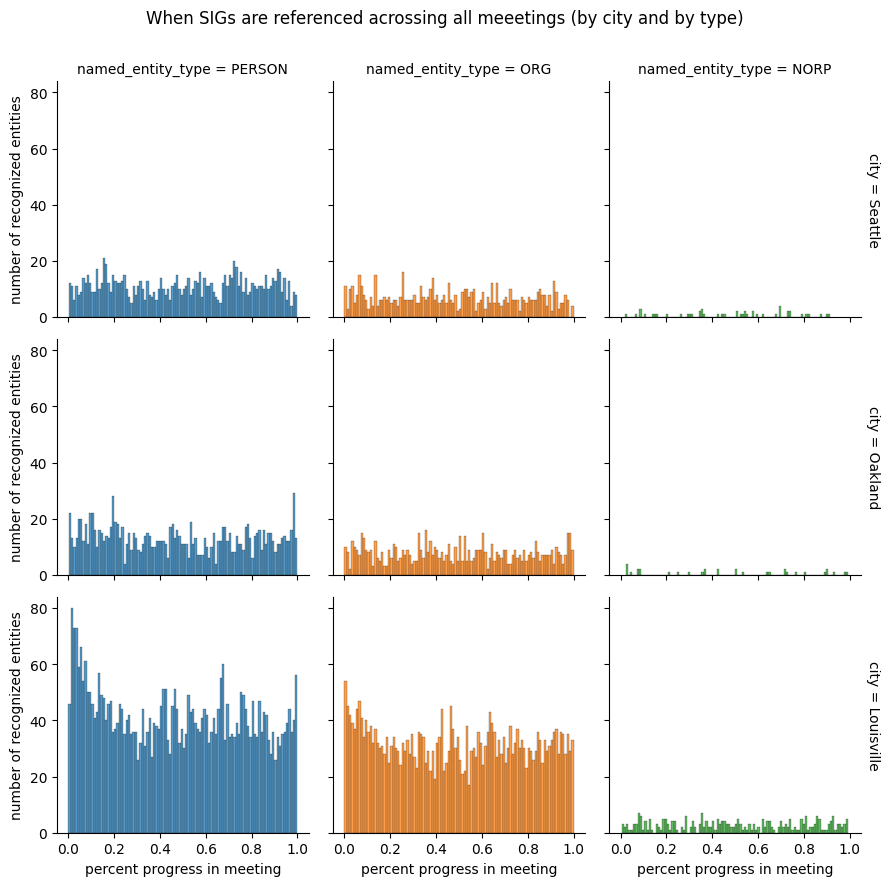

In [8]:
# this is the count, prefer the avg
g = sns.FacetGrid(per_org_norp_df, row="city", col="named_entity_type", margin_titles=True, 
                  hue="named_entity_type")
g.map_dataframe(sns.histplot, x='percent_progress_in_meeting', bins=100)
_ = g.set_axis_labels("percent progress in meeting", "number of recognized entities")
_ = g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("When SIGs are referenced acrossing all meeetings (by city and by type)")

In [9]:
# try to have bins and calculate the avg in each bin but have trouble labeling the bins
b = [i/1000 for i in range(0,1005,5)]
per_org_norp_df['bin_lab'] = pd.cut(x=per_org_norp_df['percent_progress_in_meeting'], bins=b, labels=b.remove(0), include_lowest=True)
per_org_norp_df

/var/folders/sw/7t1f8g7n6fn23gxb98fxflt40000gn/T/ipykernel_43390/2267883920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_org_norp_df['bin_lab'] = pd.cut(x=per_org_norp_df['percent_progress_in_meeting'], bins=b, labels=b.remove(0), include_lowest=True)


,Unnamed: 0,city,session_id,ner_model,sentence_index,named_entity_type,entity,percent_progress_in_meeting,bin_lab
2,2,Seattle,76bba31aaf85,spacy,1,PERSON,Alex Pedersen,0.001055,NaN
37,37,Seattle,76bba31aaf85,spacy,26,PERSON,Greg Spotts,0.027426,"(0.025, 0.03]"
40,40,Seattle,76bba31aaf85,spacy,28,PERSON,Chamber,0.029536,"(0.025, 0.03]"
45,45,Seattle,76bba31aaf85,spacy,30,PERSON,Harrell,0.031646,"(0.03, 0.035]"
53,53,Seattle,76bba31aaf85,spacy,33,ORG,Cou,0.034810,"(0.03, 0.035]"
...,...,...,...,...,...,...,...,...,...
104528,104528,Louisville,3b14573b464b,spacy,2258,PERSON,2258,0.985166,"(0.985, 0.99]"
104537,104537,Louisville,3b14573b464b,spacy,2272,NORP,Asian,0.991274,"(0.99, 0.995]"
104538,104538,Louisville,3b14573b464b,spacy,2272,ORG,LBD,0.991274,"(0.99, 0.995]"
104548,104548,Louisville,3b14573b464b,spacy,2282,PERSON,Arthur,0.995637,"(0.995, 1.0]"


In [10]:
grp = per_org_norp_df.groupby(["city", "session_id"])
grp.describe()

Unnamed: 0                                      \
                             count          mean          std      min   
city       session_id                                                    
Louisville 00298c246cfe       32.0  48897.718750    99.407352  48713.0   
           01f258e3e7c9       68.0  70464.852941   202.623043  70121.0   
           044b13b7811a       52.0  42049.019231   143.266308  41829.0   
           09cc8bb18681       23.0  26018.913043    63.623833  25934.0   
           1b536f65c47e      341.0  85608.137830  1095.714734  83727.0   
...                            ...           ...          ...      ...   
Seattle    d87f8f396ebf      147.0   4456.639456   341.884723   3898.0   
           de02e80a9141       67.0   8969.537313   144.544565   8732.0   
           e3d6d67bec42      249.0  10110.919679   315.707682   9546.0   
           e7bb3bed2636       72.0   5290.875000   100.845432   5130.0   
           e9bdfa228805       34.0   5546.823529    52.757002   5461.0   

                                                              sentence_index  \
                              25%      50%       75%      max          count   
city       session_id                                                          
Louisville 00298c246cfe  48800.75  48921.5  48976.75  49053.0           32.0   
           01f258e3e7c9  70293.75  70470.0  70653.00  70834.0           68.0   
           044b13b7811a  41912.00  42050.5  42171.75  42291.0           52.0   
           09cc8bb18681  25957.50  26016.0  26063.00  26133.0           23.0   
           1b536f65c47e  84601.00  85692.0  86435.00  87481.0          341.0   
...                           ...      ...       ...      ...            ...   
Seattle    d87f8f396ebf   4173.50   4463.0   4705.50   5105.0          147.0   
           de02e80a9141   8839.00   8980.0   9090.00   9216.0           67.0   
           e3d6d67bec42   9844.00  10091.0  10405.00  10617.0          249.0   
           e7bb3bed2636   5201.75   5296.5   5378.75   5458.0           72.0   
           e9bdfa228805   5500.25   5555.0   5590.75   5629.0           34.0   

                                      ...                   \
                                mean  ...      75%     max   
city       session_id                 ...                    
Louisville 00298c246cfe   142.437500  ...   203.50   262.0   
           01f258e3e7c9   260.338235  ...   409.75   559.0   
           044b13b7811a   172.884615  ...   275.75   378.0   
           09cc8bb18681    60.173913  ...    89.00   153.0   
           1b536f65c47e  1656.891496  ...  2341.00  3514.0   
...                              ...  ...      ...     ...   
Seattle    d87f8f396ebf   440.877551  ...   634.00   993.0   
           de02e80a9141   166.522388  ...   249.50   339.0   
           e3d6d67bec42   359.341365  ...   556.00   684.0   
           e7bb3bed2636   113.430556  ...   178.50   238.0   
           e9bdfa228805    59.500000  ...    90.75   117.0   

                        percent_progress_in_meeting                      \
                                              count      mean       std   
city       session_id                                                     
Louisville 00298c246cfe                        32.0  0.529507  0.279475   
           01f258e3e7c9                        68.0  0.440505  0.263040   
           044b13b7811a                        52.0  0.443294  0.301073   
           09cc8bb18681                        23.0  0.376087  0.286681   
           1b536f65c47e                       341.0  0.471377  0.285861   
...                                             ...       ...       ...   
Seattle    d87f8f396ebf                       147.0  0.433935  0.274085   
           de02e80a9141                        67.0  0.481279  0.295992   
           e3d6d67bec42                       249.0  0.523821  0.299785   
           e7bb3bed2636                        72.0  0.472627  0.313520   
           e9bdfa22880

In [16]:
# experiment with 1 city Seattle
import matplotlib as plt
seattle = per_org_norp_df[per_org_norp_df["city"] == "Seattle"]
a = seattle.groupby('bin_lab')["session_id"].count() / seattle["session_id"].nunique()
a = a.reset_index()
a

,bin_lab,session_id
0,"(0.004, 0.01]",0.529412
1,"(0.01, 0.015]",0.470588
2,"(0.015, 0.02]",0.470588
3,"(0.02, 0.025]",0.352941
4,"(0.025, 0.03]",0.588235
...,...,...
194,"(0.975, 0.98]",0.294118
195,"(0.98, 0.985]",0.352941
196,"(0.985, 0.99]",0.176471
197,"(0.99, 0.995]",0.411765


In [18]:
seattle.groupby('bin_lab').describe()

Unnamed: 0                                                      \
                   count         mean          std     min      25%      50%   
bin_lab                                                                        
(0.004, 0.01]        9.0  7432.333333  2978.255278  1174.0  5961.00   7949.0   
(0.01, 0.015]        8.0  6271.625000  4084.747131  1720.0  2510.50   6568.0   
(0.015, 0.02]        8.0  5775.375000  3130.207065  1178.0  4530.25   6176.5   
(0.02, 0.025]        6.0  7061.833333  3057.321535  1732.0  5842.25   8351.0   
(0.025, 0.03]       10.0  5068.300000  3083.708267    37.0  4232.25   5561.0   
...                  ...          ...          ...     ...      ...      ...   
(0.975, 0.98]        5.0  7881.000000  2118.453327  5105.0  6858.00   7633.0   
(0.98, 0.985]        6.0  7548.333333  3443.040091  2742.0  4892.75   8738.5   
(0.985, 0.99]        3.0  9617.333333  1710.691478  7642.0  9122.00  10602.0   
(0.99, 0.995]        7.0  6985.857143  3096.922797  2748.0  4672.00   7645.0   
(0.995, 1.0]         4.0  6551.750000  5361.270146  1164.0  2355.00   6684.5   

                                 sentence_index              ...          \
                    75%      max          count        mean  ...     75%   
bin_lab                                                      ...           
(0.004, 0.01]   8738.00  10628.0            9.0    3.333333  ...    4.00   
(0.01, 0.015]   9825.00  10633.0            8.0    9.000000  ...   11.00   
(0.015, 0.02]   7155.50  10637.0            8.0    8.500000  ...   11.25   
(0.02, 0.025]   9109.25   9569.0            6.0   10.500000  ...   15.50   
(0.025, 0.03]   6668.00   9573.0           10.0   18.400000  ...   24.50   
...                 ...      ...            ...         ...  ...     ...   
(0.975, 0.98]   9216.00  10593.0            5.0  660.600000  ...  698.00   
(0.98, 0.985]  10332.00  10597.0            6.0  580.166667  ...  719.50   
(0.985, 0.99]  10605.00  10608.0            3.0  654.666667  ...  677.50   
(0.99, 0.995]   9275.00  10614.0            7.0  592.857143  ...  712.50   
(0.995, 1.0]   10881.25  11674.0            4.0  635.500000  ...  797.00   

                     percent_progress_in_meeting                      \
                 max                       count      mean       std   
bin_lab                                                                
(0.004, 0.01]    5.0                         9.0  0.007312  0.001635   
(0.01, 0.015]   14.0                         8.0  0.013153  0.001439   
(0.015, 0.02]   13.0                         8.0  0.017789  0.001500   
(0.02, 0.025]   17.0                         6.0  0.022611  0.001352   
(0.025, 0.03]   28.0                        10.0  0.027957  0.001498   
...              ...                         ...       ...       ...   
(0.975, 0.98]  993.0                         5.0  0.977993  0.001715   
(0.98, 0.985]  981.0                         6.0  0.980985  0.000639   
(0.985, 0.99]  679.0                         3.0  0.987952  0.002266   
(0.99, 0.995]  992.0                         7.0  0.991752  0.001215   
(0.995, 1.0]   947.0                         4.0  0.998340  0.001381   

                                                                 
                    min       25%       50%       75%       max  
bin_lab                                                          
(0.004, 0.01]  0.005338  0.005780  0.007859  0.008671  0.009434  
(0.01, 0.015]  0.010827  0.011927  0.013780  0.014235  0.014686  
(0.015, 0.02]  0.015748  0.016954  0.017769  0.019021  0.019573  
(0.02, 0.025]  0.020833  0.021864  0.022661  0.023015  0.024781  
(0.025, 0.03]  0.025210  0.026815  0.028330  0.029167  0.029536  
...                 ...       ...       ...       ...       ...  
(0.975, 0.98]  0.975649  0.977362  0.977591  0.979592  0.979769  
(0.98, 0.985]  0.980020  0.980699  0.981050  0.981244  0.981900  
(0.985, 0.99]  0.985423  0.987030  0.988636  0.989216  0.989796  
(0.99, 0.995]  0.990291  0.

<AxesSubplot: ylabel='Count'>

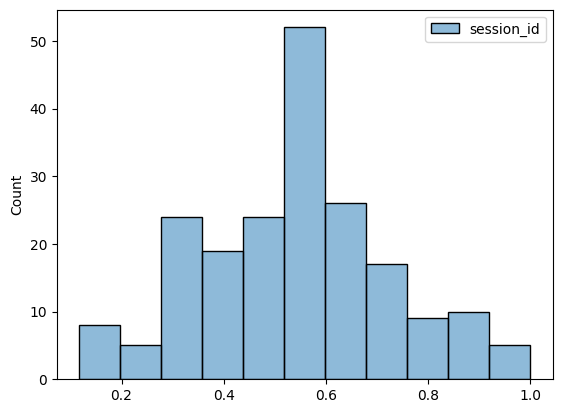

In [19]:
sns.histplot(a)
# not the avg

In [20]:
res_df.groupby(by="session_id").count()

,Unnamed: 0,city,ner_model,sentence_index,named_entity_type,entity,percent_progress_in_meeting
session_id,,,,,,,
00298c246cfe,358,358,358,358,358,358,358
01f258e3e7c9,754,754,754,754,754,754,754
044b13b7811a,486,486,486,486,486,486,486
09cc8bb18681,220,220,220,220,220,220,220
0b73859e8b6a,874,874,874,874,874,872,874
...,...,...,...,...,...,...,...
e9bdfa228805,180,180,180,180,180,180,180
ebf9ee5aaee3,1158,1158,1158,1158,1158,1158,1158
f19af512dd71,498,498,498,498,498,498,498


In [22]:
NORP_df = res_df[res_df["named_entity_type"] == "NORP"]
NORP_df

,Unnamed: 0,city,session_id,ner_model,sentence_index,named_entity_type,entity,percent_progress_in_meeting
159,159,Seattle,76bba31aaf85,spacy,100,NORP,experi,0.105485
458,458,Seattle,76bba31aaf85,spacy,334,NORP,Slivers,0.352321
2432,2432,Seattle,4d5bb0e3a2e7,spacy,519,NORP,Eletes,0.692924
2435,2435,Seattle,4d5bb0e3a2e7,spacy,521,NORP,Democrats,0.695594
2440,2440,Seattle,4d5bb0e3a2e7,spacy,523,NORP,Democratic,0.698264
...,...,...,...,...,...,...,...,...
104009,104009,Louisville,3b14573b464b,spacy,1756,NORP,Kramer,0.766143
104184,104184,Louisville,3b14573b464b,spacy,1907,NORP,Councilman,0.832024
104399,104399,Louisville,3b14573b464b,spacy,2117,NORP,Councilman,0.923647
104431,104431,Louisville,3b14573b464b,spacy,2147,NORP,German,0.936736


In [23]:
NORP_df.groupby(by='session_id').mean()

/var/folders/sw/7t1f8g7n6fn23gxb98fxflt40000gn/T/ipykernel_43390/1208428818.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  NORP_df.groupby(by='session_id').mean()


,Unnamed: 0,sentence_index,percent_progress_in_meeting
session_id,,,
00298c246cfe,48932.000000,168.000000,0.624535
01f258e3e7c9,70578.750000,344.750000,0.583333
044b13b7811a,42066.000000,192.500000,0.493590
09cc8bb18681,26081.000000,104.000000,0.650000
146b621e98f1,8495.500000,349.750000,0.687132
...,...,...,...
e4bdcf6cb164,73559.375000,737.250000,0.624259
e7bb3bed2636,5188.000000,35.000000,0.145833
ebf9ee5aaee3,50964.200000,466.200000,0.454386


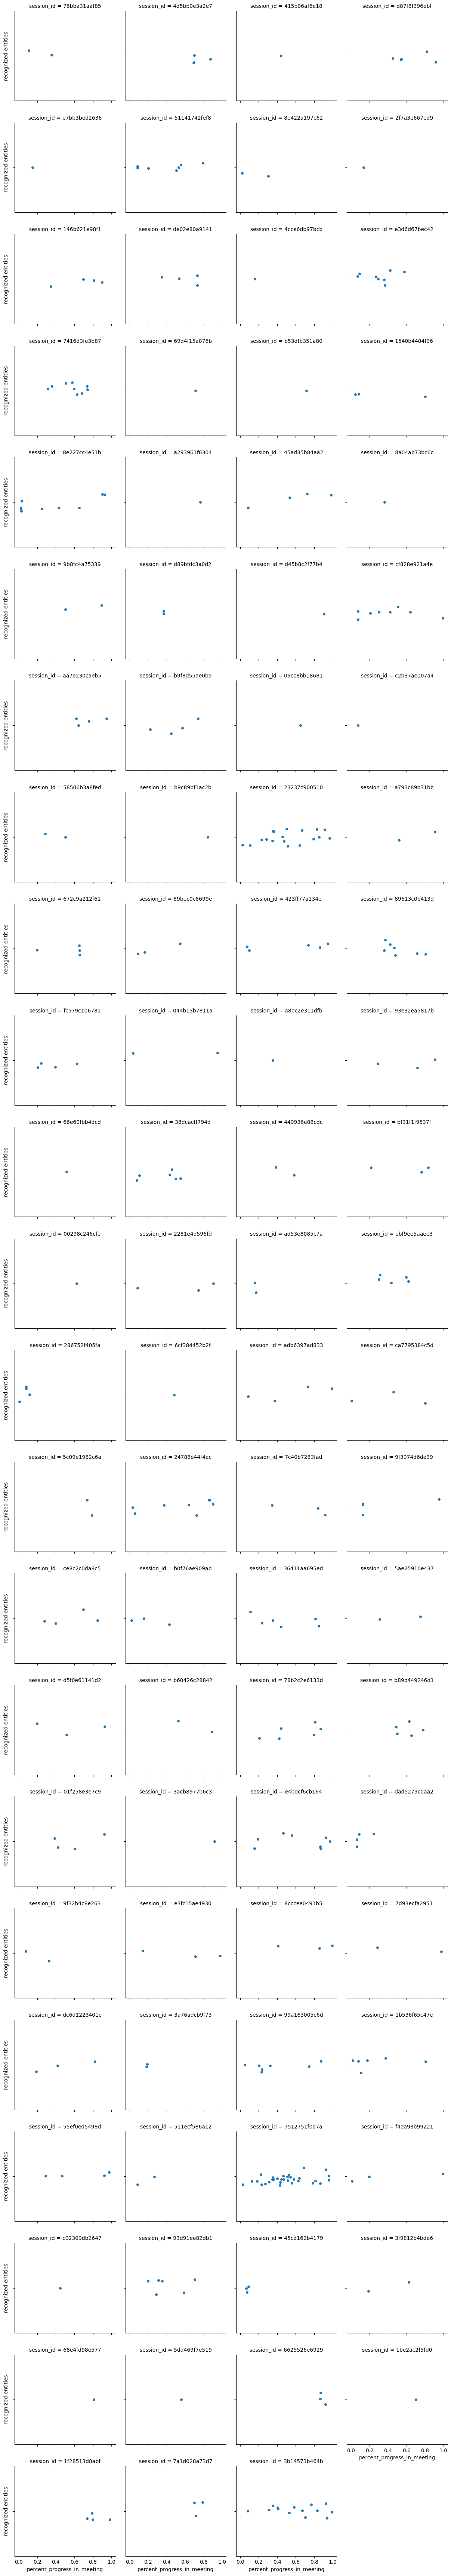

In [24]:
g = sns.FacetGrid(NORP_df, col="session_id", margin_titles=True, col_wrap=4)
g.map_dataframe(sns.stripplot, x="percent_progress_in_meeting")
_ = g.set_axis_labels("percent_progress_in_meeting", "recognized entities")

### explore high freq words

In [85]:
per_org_norp_df[per_org_norp_df["entity"].str.contains("community", na=False, case=False)].entity

25570           Berrytown Community Center
25575                     Community Partne
26628                    Community Affairs
29798                the Clifton Community
29800                the Clifton Community
30775               the Muslim Community C
31676             the Clinton Community Co
31715            Clifton Community Council
34429                            Community
35995                            Community
40911        The Clifton Community Council
41702                            Community
43463                            Community
44892                 Louisville Community
48605              Jewish Community Center
50150                Community Development
50513                            Community
52013                            Community
52525                    Community Service
57193                            Community
58911                    Community Affairs
60760                            Community
61606                            Community
62279      

In [123]:
filter_list = ['counc', 'city', 'committee', 'department', 'madam', 'admin', 'attorney', 'clerk', 'mayor', 'unmute', 'american', 'christian', 'asian', 'kentuckians', 'catholic', 'spanish', 'hispanic']
seattle_council_mem = ['Nelson', 'Herbold', 'Juarez', 'Lewis', 'Morales', 'Mosqueda', 'Pedersen', 'Sawant', 'Strauss']
oakland_council_mem = ['Thao', 'Bas', 'Gallo', 'Parker', 'Ruby', 'Kaplan', 'Fife', 'Jenkins', 'Reiskin', 'Kalb', 'Ramachandran', 'Reid', 'Reed']
louisville_council_mem = ['Maloney', 'Dickinson', 'Leh', 'Fahey', 'Most', 'Hamlington', 'Hoefner', 'Hollander']
exact_match = ['county', 'community']

In [135]:
per_org_norp_df

,city,session_id,ner_model,sentence_index,named_entity_type,entity
2,Seattle,76bba31aaf85,spacy,1,PERSON,Alex Pedersen
37,Seattle,76bba31aaf85,spacy,26,PERSON,Greg Spotts
40,Seattle,76bba31aaf85,spacy,28,PERSON,Chamber
45,Seattle,76bba31aaf85,spacy,30,PERSON,Harrell
53,Seattle,76bba31aaf85,spacy,33,ORG,Cou
...,...,...,...,...,...,...
104435,Louisville,3b14573b464b,spacy,2258,PERSON,2258
104444,Louisville,3b14573b464b,spacy,2272,NORP,Asian
104445,Louisville,3b14573b464b,spacy,2272,ORG,LBD
104455,Louisville,3b14573b464b,spacy,2282,PERSON,Arthur


In [136]:
# exact match, no substring
filtered_per_org_norp_df = per_org_norp_df[~per_org_norp_df["entity"].str.lower().isin(exact_match)]
filtered_per_org_norp_df

,city,session_id,ner_model,sentence_index,named_entity_type,entity
2,Seattle,76bba31aaf85,spacy,1,PERSON,Alex Pedersen
37,Seattle,76bba31aaf85,spacy,26,PERSON,Greg Spotts
40,Seattle,76bba31aaf85,spacy,28,PERSON,Chamber
45,Seattle,76bba31aaf85,spacy,30,PERSON,Harrell
53,Seattle,76bba31aaf85,spacy,33,ORG,Cou
...,...,...,...,...,...,...
104435,Louisville,3b14573b464b,spacy,2258,PERSON,2258
104444,Louisville,3b14573b464b,spacy,2272,NORP,Asian
104445,Louisville,3b14573b464b,spacy,2272,ORG,LBD
104455,Louisville,3b14573b464b,spacy,2282,PERSON,Arthur


In [149]:
# filter by substring, case insensitive
filter_pattern = '|'.join(seattle_council_mem) +'|' + '|'.join(oakland_council_mem) +'|' + '|'.join(louisville_council_mem) + '|' + '|'.join(filter_list)
filtered_per_org_norp_df = filtered_per_org_norp_df[~filtered_per_org_norp_df["entity"].str.lower().str.contains(filter_pattern, case=False)]

,city,session_id,ner_model,sentence_index,named_entity_type,entity
37,Seattle,76bba31aaf85,spacy,26,PERSON,Greg Spotts
40,Seattle,76bba31aaf85,spacy,28,PERSON,Chamber
45,Seattle,76bba31aaf85,spacy,30,PERSON,Harrell
53,Seattle,76bba31aaf85,spacy,33,ORG,Cou
55,Seattle,76bba31aaf85,spacy,34,PERSON,Spotts
...,...,...,...,...,...,...
104434,Louisville,3b14573b464b,spacy,2257,ORG,Office Buildings
104435,Louisville,3b14573b464b,spacy,2258,PERSON,2258
104445,Louisville,3b14573b464b,spacy,2272,ORG,LBD
104455,Louisville,3b14573b464b,spacy,2282,PERSON,Arthur
